# Fake News Detection

# Import Libraries

In [ ]:
!pip install torchtext sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup, set_seed
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle
import os

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Define Constant & Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ENVIRONMENT = '/content/drive/MyDrive/BT5153/Group Project/Model/V4' # To be updated by user
DATA_PATH = 'news.csv' # To be updated by user (relative path to the environment)
RANDOM_SEED = 42
os.chdir(ENVIRONMENT)
results = {} # To store model training and evaluation results

In [ ]:
ls

 bow_confusion_matrix.png                glove_confusion_matrix.png
 bow_logistic_model.pkl                  glove_logistic_model.pkl
'Copy of fake_news_detection_V4.ipynb'   news.csv
 fake_news_detection_V4.ipynb            tfidf_confusion_matrix.png
 glove.6B.100d.txt                       tfidf_logistic_model.pkl


### Set Random Seeds For Reproducibility

In [ ]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set seed for Hugging Face Transformers (if used)
set_seed(RANDOM_SEED)

### Device Configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Define Utility Functions

### (1) Text Preprocessing Function

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|\#\w+', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

### (2) Text Preprocessing Pipeline

In [ ]:
def preprocess_df(df, text_column, label_column):
    # Drop missing values
    df = df.dropna(subset=[text_column, label_column])

    # Preprocess text
    df['processed_text'] = df[text_column].apply(preprocess_text)

    return df

### (3) Model Comparison Function

In [ ]:
def compare_models(results):
    models = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet', 'orange'])

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}', ha='center', va='bottom')

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

### (4) Inference Function

In [ ]:
def predict_fake_news(text, models_dict):
    # Preprocess the text
    processed_text = preprocess_text(text)

    results = {}

    # 1. BoW + Logistic Regression
    if 'bow' in models_dict:
        model, vectorizer = models_dict['bow']
        text_bow = vectorizer.transform([processed_text])
        pred = model.predict(text_bow)[0]
        prob = model.predict_proba(text_bow)[0]
        results['BoW + Logistic Regression'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                                               'confidence': prob[1] if pred == 1 else prob[0]}

    # 2. TF-IDF + Logistic Regression
    if 'tfidf' in models_dict:
        model, vectorizer = models_dict['tfidf']
        text_tfidf = vectorizer.transform([processed_text])
        pred = model.predict(text_tfidf)[0]
        prob = model.predict_proba(text_tfidf)[0]
        results['TF-IDF + Logistic Regression'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                                                  'confidence': prob[1] if pred == 1 else prob[0]}

    # 3. GloVe + Logistic Regression
    if 'glove' in models_dict and 'glove_vectors' in models_dict:
        model = models_dict['glove']
        word_vectors = models_dict['glove_vectors']
        text_glove = np.array([text_to_glove_vector(processed_text, word_vectors)])
        pred = model.predict(text_glove)[0]
        prob = model.predict_proba(text_glove)[0]
        results['GloVe + Logistic Regression'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                                                 'confidence': prob[1] if pred == 1 else prob[0]}

    # 4. GloVe + LSTM
    if 'lstm' in models_dict and 'glove_vectors' in models_dict:
        model = models_dict['lstm']
        word_vectors = models_dict['glove_vectors']

        # Create a mini batch for the single text
        dataset = NewsDataset([processed_text], [0], word_vectors)  # Label doesn't matter for prediction
        dataloader = DataLoader(dataset, batch_size=1)

        model.eval()
        with torch.no_grad():
            for embeddings, _ in dataloader:
                embeddings = embeddings.to(device)
                outputs = model(embeddings)
                _, predicted = torch.max(outputs, 1)
                prob = F.softmax(outputs, dim=1)

                pred = predicted.item()
                confidence = prob[0][pred].item()

                results['GloVe + LSTM'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                                          'confidence': confidence}

    # 5. BERT
    if 'bert' in models_dict:
        bert = models_dict['bert']
        pred = bert.evaluate([processed_text])[0]
        results['BERT'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                          'confidence': None}  # BERT confidence not easily accessible

    # 6. Sentence Transformer
    if 'sentence_transformer' in models_dict and 'sentence_transformer_model' in models_dict:
        clf = models_dict['sentence_transformer_model']
        st_encoder = models_dict['sentence_transformer']

        # Encode the text
        embedding = st_encoder.encode([processed_text])[0].reshape(1, -1)

        # Predict
        pred = clf.predict(embedding)[0]
        prob = clf.predict_proba(embedding)[0]

        results['Sentence Transformer'] = {'prediction': 'Fake' if pred == 1 else 'Real',
                                          'confidence': prob[1] if pred == 1 else prob[0]}

    return results

# Load Dataset

In [ ]:
df = pd.read_csv(DATA_PATH)

# EDA

### Data Inspection

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
selected_features = ['label', 'text']
df = df[selected_features]

In [ ]:
df.head()

,label,text
0,FAKE,"Daniel Greenfield, a Shillman Journalism Fello..."
1,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,REAL,U.S. Secretary of State John F. Kerry said Mon...
3,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,REAL,It's primary day in New York and front-runners...


### Data Type & Structure

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   6335 non-null   object
 1   text    6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB


### Null Values

In [ ]:
df.isnull().sum()

,0
label,0
text,0


### Duplicates

In [ ]:
df.duplicated().sum()

np.int64(275)

# Data Preprocessing

### Drop Duplicates

In [ ]:
df.drop_duplicates(inplace=True)
print('Duplicates in DataFrame:', df.duplicated().sum())

Duplicates in DataFrame: 0


### Test Proprocessing

In [ ]:
text_column = 'text'
label_column = 'label'

df = preprocess_df(df, text_column, label_column)
# val = preprocess_df(val, text_column, label_column)
# test = preprocess_df(test, text_column, label_column)

In [ ]:
print(df.head())

  label                                               text  \
0  FAKE  Daniel Greenfield, a Shillman Journalism Fello...   
1  FAKE  Google Pinterest Digg Linkedin Reddit Stumbleu...   
2  REAL  U.S. Secretary of State John F. Kerry said Mon...   
3  FAKE  — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4  REAL  It's primary day in New York and front-runners...   

                                      processed_text  
0  daniel greenfield a shillman journalism fellow...  
1  google pinterest digg linkedin reddit stumbleu...  
2  us secretary of state john f kerry said monday...  
3  — kaydee king november the lesson from tonight...  
4  its primary day in new york and frontrunners h...  


# Data Visualization

### Class Distribution

In [ ]:
class_dist = df.label.value_counts(normalize=True)
class_dist

,proportion
label,
FAKE,0.506766
REAL,0.493234


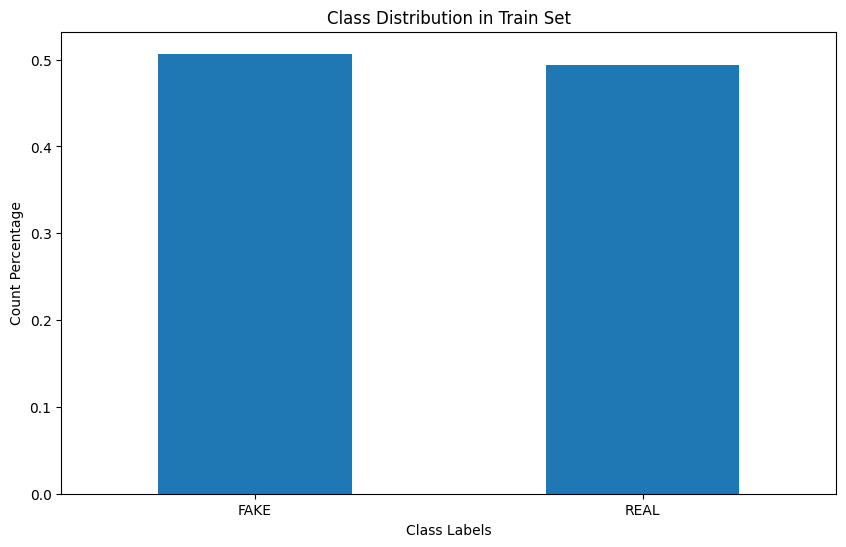

In [ ]:
plt.figure(figsize=(10,6))
class_dist.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Class Labels')
plt.ylabel('Count Percentage')
plt.title('Class Distribution in Train Set')
plt.show()

# Feature Engineering

### Label Assignment
The goal is to make this a binary classification problem to make it easier for users to understand. As such, we map 'true', 'mostly-true', and 'half-true' to 0 (i.e., Real News) and 'barely-true', 'false', and 'pants-fire' to 1 (i.e., Fake News).

In [ ]:
# Function to map labels to binary values
def map_to_binary(label):
    """
    Maps labels to binary values:
    - 'true', 'mostly-true', 'half-true' -> 0 (more truthful)
    - all other labels -> 1 (less truthful)
    """
    truthful_labels = ['REAL']
    return 0 if label in truthful_labels else 1

In [ ]:
df['binary_class'] = df['label'].apply(map_to_binary)

In [ ]:
df

,label,text,processed_text,binary_class
0,FAKE,"Daniel Greenfield, a Shillman Journalism Fello...",daniel greenfield a shillman journalism fellow...,1
1,FAKE,Google Pinterest Digg Linkedin Reddit Stumbleu...,google pinterest digg linkedin reddit stumbleu...,1
2,REAL,U.S. Secretary of State John F. Kerry said Mon...,us secretary of state john f kerry said monday...,0
3,FAKE,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",— kaydee king november the lesson from tonight...,1
4,REAL,It's primary day in New York and front-runners...,its primary day in new york and frontrunners h...,0
...,...,...,...,...
6330,REAL,The State Department told the Republican Natio...,the state department told the republican natio...,0
6331,FAKE,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,the ‘p’ in pbs should stand for ‘plutocratic’ ...,1
6332,FAKE,Anti-Trump Protesters Are Tools of the Oligar...,antitrump protesters are tools of the oligarch...,1
6333,REAL,"ADDIS ABABA, Ethiopia —President Obama convene...",addis ababa ethiopia —president obama convened...,0


# Train, Validation, Test Assignment (70-20-10)

In [ ]:
X = df['processed_text']
y = df['binary_class']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(20/90), random_state=RANDOM_SEED, stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Training set size: 4242
Validation set size: 1212
Test set size: 606


In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# (1) BoW + Logistic Regression (L1-regularized)

In [ ]:
def bow_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n1. BoW + Logistic Regression (with L1 regularization)")

    # Create a Bag of Words representation
    vectorizer = CountVectorizer(max_features=10000, stop_words='english')
    X_train_bow = vectorizer.fit_transform(X_train)
    X_val_bow = vectorizer.transform(X_val)
    X_test_bow = vectorizer.transform(X_test)

    scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices don't support centering
    X_train_bow = scaler.fit_transform(X_train_bow)
    X_val_bow = scaler.transform(X_val_bow)
    X_test_bow = scaler.transform(X_test_bow)

    # Train a Logistic Regression model with L1 regularization
    model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=1000, random_state=42)
    model.fit(X_train_bow, y_train)

    # Predictions and probabilities for train, validation, and test sets
    y_train_pred = model.predict(X_train_bow)
    y_val_pred = model.predict(X_val_bow)
    y_test_pred = model.predict(X_test_bow)

    y_train_proba = model.predict_proba(X_train_bow)
    y_val_proba = model.predict_proba(X_val_bow)
    y_test_proba = model.predict_proba(X_test_bow)

    # Evaluate the model: accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compute log loss for train, validation, and test sets
    train_loss = log_loss(y_train, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    test_loss = log_loss(y_test, y_test_proba)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))

    # Compute additional evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: BoW + Logistic Regression')
    plt.tight_layout()
    plt.savefig('bow_confusion_matrix.png')
    plt.close()

    # Save the model
    with open('bow_logistic_model.pkl', 'wb') as f:
        pickle.dump((model, vectorizer), f)

    return model, vectorizer, test_acc

### Run model pipeline

In [ ]:
bow_model, bow_vectorizer, bow_accuracy = bow_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test)
results['BoW + LR'] = bow_accuracy


1. BoW + Logistic Regression (with L1 regularization)
Train Loss: 0.0927 | Train Accuracy: 0.9840
Validation Loss: 0.2230 | Validation Accuracy: 0.9183
Test Loss: 0.2009 | Test Accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       299
           1       0.91      0.95      0.93       307

    accuracy                           0.93       606
   macro avg       0.93      0.93      0.93       606
weighted avg       0.93      0.93      0.93       606

Test Set Evaluation Metrics:
Accuracy: 0.9290
Precision: 0.9298
Recall: 0.9290
F1 Score: 0.9290


# (2) TF-IDF + Logistic Regression (L1-regularized)

In [ ]:
# 2. TF-IDF + Logistic Regression (with L1)
def tfidf_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n2. TF-IDF + Logistic Regression (with L1)")

    # Create a TF-IDF representation
    vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)

    scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices don't support centering
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_val_tfidf = scaler.transform(X_val_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)

    # Train a Logistic Regression model with L1 regularization
    model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=1000, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Predictions and probabilities for train, validation, and test sets
    y_train_pred = model.predict(X_train_tfidf)
    y_val_pred = model.predict(X_val_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    y_train_proba = model.predict_proba(X_train_tfidf)
    y_val_proba = model.predict_proba(X_val_tfidf)
    y_test_proba = model.predict_proba(X_test_tfidf)

    # Evaluate the model: accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compute log loss for train, validation, and test sets
    train_loss = log_loss(y_train, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    test_loss = log_loss(y_test, y_test_proba)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    # Compute additional evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: TF-IDF + Logistic Regression')
    plt.tight_layout()
    plt.savefig('tfidf_confusion_matrix.png')
    plt.close()

    # Save the model
    with open('tfidf_logistic_model.pkl', 'wb') as f:
        pickle.dump((model, vectorizer), f)

    return model, vectorizer, test_acc

### Run model pipeline

In [ ]:
tfidf_model, tfidf_vectorizer, tfidf_accuracy = tfidf_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test)
results['TF-IDF + LR'] = tfidf_accuracy


2. TF-IDF + Logistic Regression (with L1)
Train Loss: 0.0547 | Train Accuracy: 0.9998
Validation Loss: 0.2087 | Validation Accuracy: 0.9183
Test Loss: 0.1840 | Test Accuracy: 0.9356
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       299
           1       0.94      0.93      0.94       307

    accuracy                           0.94       606
   macro avg       0.94      0.94      0.94       606
weighted avg       0.94      0.94      0.94       606

Test Set Evaluation Metrics:
Accuracy: 0.9356
Precision: 0.9357
Recall: 0.9356
F1 Score: 0.9356


# GloVe

### Load GloVe Embeddings

In [ ]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            # Each line: word vec[0] vec[1] ... vec[N]
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

### Tokenization using GloVe

In [ ]:
def text_to_glove_vector(text: str, glove, vector_size: int = 100) -> np.ndarray:
    tokens = word_tokenize(text.lower())

    # If the GloVe object has a 'stoi' attribute, assume glove[token] returns a torch tensor.
    if hasattr(glove, 'stoi'):
        vectors = [
            glove[token].cpu().detach().numpy()
            for token in tokens if token in glove.stoi
        ]
    else:
        # Otherwise, assume glove is a dictionary mapping tokens to vectors (as lists or np.ndarray).
        vectors = [
            np.array(glove[token])
            for token in tokens if token in glove
        ]

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# (3) GloVe + Logistic Regression (L1-regularized)

In [ ]:
def glove_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n3. GloVe + Logistic Regression (with L1)")

    # Load GloVe embeddings
    word_vectors = load_glove_embeddings('glove.6B.100d.txt')

    # Convert texts to document vectors
    print("Converting texts to GloVe vectors...")
    X_train_glove = np.array([text_to_glove_vector(text, word_vectors) for text in tqdm(X_train)])
    X_val_glove = np.array([text_to_glove_vector(text, word_vectors) for text in tqdm(X_val)])
    X_test_glove = np.array([text_to_glove_vector(text, word_vectors) for text in tqdm(X_test)])

    scaler = StandardScaler(with_mean=False)  # with_mean=False because sparse matrices don't support centering
    X_train_glove = scaler.fit_transform(X_train_glove)
    X_val_glove = scaler.transform(X_val_glove)
    X_test_glove = scaler.transform(X_test_glove)

    # Train a Logistic Regression model with L1 regularization
    model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=1000, random_state=42)
    model.fit(X_train_glove, y_train)

    # Predictions and probabilities for train, validation, and test sets
    y_train_pred = model.predict(X_train_glove)
    y_val_pred = model.predict(X_val_glove)
    y_test_pred = model.predict(X_test_glove)

    y_train_proba = model.predict_proba(X_train_glove)
    y_val_proba = model.predict_proba(X_val_glove)
    y_test_proba = model.predict_proba(X_test_glove)

    # Evaluate the model: accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compute log loss for train, validation, and test sets
    train_loss = log_loss(y_train, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    test_loss = log_loss(y_test, y_test_proba)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    # Compute additional evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: GloVe + Logistic Regression')
    plt.tight_layout()
    plt.savefig('glove_confusion_matrix.png')
    plt.close()

    # Save the model
    with open('glove_logistic_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    return model, test_acc

### Run the Pipeline

In [ ]:
glove_model, glove_accuracy = glove_logistic_regression(X_train, y_train, X_val, y_val, X_test, y_test)
results['GloVe + LR'] = glove_accuracy


3. GloVe + Logistic Regression (with L1)
Converting texts to GloVe vectors...






  0%|          | 0/4242 [00:00<?, ?it/s]



  1%|          | 47/4242 [00:00<00:09, 443.32it/s]



  2%|▏         | 92/4242 [00:00<00:09, 421.09it/s]



  3%|▎         | 135/4242 [00:00<00:10, 373.52it/s]



  4%|▍         | 176/4242 [00:00<00:10, 380.89it/s]



  5%|▌         | 215/4242 [00:00<00:10, 374.56it/s]



  6%|▌         | 257/4242 [00:00<00:10, 387.64it/s]



  7%|▋         | 306/4242 [00:00<00:09, 417.40it/s]



  8%|▊         | 356/4242 [00:00<00:08, 438.32it/s]



  9%|▉         | 401/4242 [00:01<00:09, 388.17it/s]



 11%|█         | 451/4242 [00:01<00:09, 418.03it/s]



 12%|█▏        | 499/4242 [00:01<00:08, 434.83it/s]



 13%|█▎        | 544/4242 [00:01<00:08, 416.47it/s]



 14%|█▍        | 587/4242 [00:01<00:09, 403.14it/s]



 15%|█▍        | 628/4242 [00:01<00:09, 400.47it/s]



 16%|█▌        | 674/4242 [00:01<00:08, 416.13it/s]



 17%|█▋        | 716/4242 [00:01<00:08, 409.27it/s]



 18%|█▊        | 758/4242 [00:01<00:08, 407.26it/s]



 19%|█▉        | 80

Train Loss: 0.3459 | Train Accuracy: 0.8569
Validation Loss: 0.3434 | Validation Accuracy: 0.8540
Test Loss: 0.3621 | Test Accuracy: 0.8449
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       299
           1       0.84      0.86      0.85       307

    accuracy                           0.84       606
   macro avg       0.85      0.84      0.84       606
weighted avg       0.85      0.84      0.84       606

Test Set Evaluation Metrics:
Accuracy: 0.8449
Precision: 0.8452
Recall: 0.8449
F1 Score: 0.8448


# (4) GloVe + LSTM

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, glove, max_length=100, embedding_dim=100):
        self.texts = texts
        self.labels = labels
        self.glove = glove
        self.max_length = max_length
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize and truncate to max_length tokens
        tokens = word_tokenize(text.lower())[:self.max_length]

        embeddings = []
        for token in tokens:
            if hasattr(self.glove, 'stoi'):
                # If glove has attribute 'stoi', use that to check token membership
                if token in self.glove.stoi:
                    embeddings.append(self.glove[token].cpu().detach().numpy())
                else:
                    embeddings.append(np.zeros(self.embedding_dim))
            else:
                # Otherwise, assume glove is a dictionary
                if token in self.glove:
                    embeddings.append(np.array(self.glove[token]))
                else:
                    embeddings.append(np.zeros(self.embedding_dim))

        # Padding to ensure fixed sequence length
        padding_length = self.max_length - len(embeddings)
        if padding_length > 0:
            embeddings.extend([np.zeros(self.embedding_dim) for _ in range(padding_length)])

        # Convert the list of embeddings and label to torch tensors
        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return embeddings, label

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers=2, bidirectional=True, dropout=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: [batch size, seq length, embedding dim]

        # lstm_out shape: [batch size, seq length, hidden dim * (2 if bidirectional else 1)]
        lstm_out, (hidden, cell) = self.lstm(x)

        # Get the output from the last time step
        if self.lstm.bidirectional:
            # Concatenate the last hidden state from both directions
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1]

        # Apply dropout and the final fully connected layer
        hidden = self.dropout(hidden)
        output = self.fc(hidden)

        return output

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for embeddings, labels in tqdm(data_loader):
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(embeddings)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).float().mean()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in tqdm(data_loader):
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(embeddings)

            # Compute loss
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == labels).float().mean()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_preds.extend(predicted.cpu().detach().tolist())
            all_labels.extend(labels.cpu().detach().tolist())

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), all_preds, all_labels

In [ ]:
def glove_lstm(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32, epochs=5):
    print("\n4. GloVe + LSTM")

    # Load GloVe embeddings
    word_vectors = load_glove_embeddings('glove.6B.100d.txt')

    # Create datasets
    train_dataset = NewsDataset(X_train, y_train, word_vectors)
    val_dataset = NewsDataset(X_val, y_val, word_vectors)
    test_dataset = NewsDataset(X_test, y_test, word_vectors)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = LSTMModel(embedding_dim=100, hidden_dim=128, output_dim=2).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'glove_lstm_model.pt')
            print("Model saved!")

    # Load the best model
    model.load_state_dict(torch.load('glove_lstm_model.pt'))

    # Evaluate on test set
    test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(all_labels, all_preds))
    # Compute additional evaluation metrics for test set
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: GloVe + LSTM')
    plt.tight_layout()
    plt.savefig('glove_lstm_confusion_matrix.png')
    plt.close()

    return model, test_acc

### Run model pipeline

In [ ]:
lstm_model, lstm_accuracy = glove_lstm(X_train, y_train, X_val, y_val, X_test, y_test)
results['GloVe + LSTM'] = lstm_accuracy


4. GloVe + LSTM
Epoch 1/5






  0%|          | 0/133 [00:00<?, ?it/s]<ipython-input-140-285797788d2f>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float32)




  1%|          | 1/133 [00:00<00:22,  5.96it/s]



  2%|▏         | 2/133 [00:00<00:20,  6.43it/s]



  2%|▏         | 3/133 [00:00<00:19,  6.50it/s]



  3%|▎         | 4/133 [00:00<00:20,  6.42it/s]



  4%|▍         | 5/133 [00:00<00:20,  6.30it/s]



  5%|▍         | 6/133 [00:00<00:19,  6.52it/s]



  5%|▌         | 7/133 [00:01<00:19,  6.44it/s]



  6%|▌         | 8/133 [00:01<00:19,  6.45it/s]



  7%|▋         | 9/133 [00:01<00:19,  6.48it/s]



  8%|▊         | 10/133 [00:01<00:19,  6.24it/s]



  8%|▊         | 11/133 [00:01<00:19,  6.21it/s]



  9%|▉         | 12/133 [00:

Train Loss: 0.5010 | Train Acc: 0.7519
Validation Loss: 0.3923 | Validation Acc: 0.8281
Model saved!
Epoch 2/5






  0%|          | 0/133 [00:00<?, ?it/s]



  1%|          | 1/133 [00:00<00:20,  6.42it/s]



  2%|▏         | 2/133 [00:00<00:21,  6.10it/s]



  2%|▏         | 3/133 [00:00<00:20,  6.33it/s]



  3%|▎         | 4/133 [00:00<00:20,  6.26it/s]



  4%|▍         | 5/133 [00:00<00:20,  6.10it/s]



  5%|▍         | 6/133 [00:00<00:20,  6.13it/s]



  5%|▌         | 7/133 [00:01<00:19,  6.31it/s]



  6%|▌         | 8/133 [00:01<00:20,  6.20it/s]



  7%|▋         | 9/133 [00:01<00:19,  6.31it/s]



  8%|▊         | 10/133 [00:01<00:19,  6.25it/s]



  8%|▊         | 11/133 [00:01<00:19,  6.38it/s]



  9%|▉         | 12/133 [00:01<00:19,  6.12it/s]



 10%|▉         | 13/133 [00:02<00:18,  6.33it/s]



 11%|█         | 14/133 [00:02<00:18,  6.41it/s]



 11%|█▏        | 15/133 [00:02<00:18,  6.47it/s]



 12%|█▏        | 16/133 [00:02<00:18,  6.25it/s]



 13%|█▎        | 17/133 [00:02<00:18,  6.15it/s]



 14%|█▎        | 18/133 [00:02<00:19,  6.03it/s]



 14%|█▍        | 19/133 [0

Train Loss: 0.3536 | Train Acc: 0.8443
Validation Loss: 0.3202 | Validation Acc: 0.8732
Model saved!
Epoch 3/5






  0%|          | 0/133 [00:00<?, ?it/s]



  1%|          | 1/133 [00:00<00:19,  6.62it/s]



  2%|▏         | 2/133 [00:00<00:22,  5.92it/s]



  2%|▏         | 3/133 [00:00<00:23,  5.56it/s]



  3%|▎         | 4/133 [00:00<00:22,  5.78it/s]



  4%|▍         | 5/133 [00:00<00:21,  5.91it/s]



  5%|▍         | 6/133 [00:01<00:22,  5.74it/s]



  5%|▌         | 7/133 [00:01<00:20,  6.06it/s]



  6%|▌         | 8/133 [00:01<00:19,  6.29it/s]



  7%|▋         | 9/133 [00:01<00:19,  6.20it/s]



  8%|▊         | 10/133 [00:01<00:20,  6.13it/s]



  8%|▊         | 11/133 [00:01<00:19,  6.29it/s]



  9%|▉         | 12/133 [00:01<00:19,  6.23it/s]



 10%|▉         | 13/133 [00:02<00:19,  6.24it/s]



 11%|█         | 14/133 [00:02<00:18,  6.40it/s]



 11%|█▏        | 15/133 [00:02<00:18,  6.31it/s]



 12%|█▏        | 16/133 [00:02<00:17,  6.54it/s]



 13%|█▎        | 17/133 [00:02<00:18,  6.37it/s]



 14%|█▎        | 18/133 [00:02<00:18,  6.34it/s]



 14%|█▍        | 19/133 [0

Train Loss: 0.3296 | Train Acc: 0.8559
Validation Loss: 0.2688 | Validation Acc: 0.8905
Model saved!
Epoch 4/5






  0%|          | 0/133 [00:00<?, ?it/s]



  1%|          | 1/133 [00:00<00:19,  6.65it/s]



  2%|▏         | 2/133 [00:00<00:20,  6.40it/s]



  2%|▏         | 3/133 [00:00<00:19,  6.57it/s]



  3%|▎         | 4/133 [00:00<00:20,  6.32it/s]



  4%|▍         | 5/133 [00:00<00:22,  5.62it/s]



  5%|▍         | 6/133 [00:00<00:21,  5.97it/s]



  5%|▌         | 7/133 [00:01<00:21,  5.99it/s]



  6%|▌         | 8/133 [00:01<00:21,  5.92it/s]



  7%|▋         | 9/133 [00:01<00:21,  5.90it/s]



  8%|▊         | 10/133 [00:01<00:21,  5.78it/s]



  8%|▊         | 11/133 [00:01<00:20,  5.90it/s]



  9%|▉         | 12/133 [00:02<00:20,  5.99it/s]



 10%|▉         | 13/133 [00:02<00:19,  6.08it/s]



 11%|█         | 14/133 [00:02<00:19,  6.09it/s]



 11%|█▏        | 15/133 [00:02<00:19,  6.12it/s]



 12%|█▏        | 16/133 [00:02<00:18,  6.32it/s]



 13%|█▎        | 17/133 [00:02<00:17,  6.45it/s]



 14%|█▎        | 18/133 [00:02<00:17,  6.40it/s]



 14%|█▍        | 19/133 [0

Train Loss: 0.2755 | Train Acc: 0.8873
Validation Loss: 0.2819 | Validation Acc: 0.8831
Epoch 5/5






  0%|          | 0/133 [00:00<?, ?it/s]



  1%|          | 1/133 [00:00<00:18,  7.00it/s]



  2%|▏         | 2/133 [00:00<00:21,  6.14it/s]



  2%|▏         | 3/133 [00:00<00:21,  6.01it/s]



  3%|▎         | 4/133 [00:00<00:22,  5.68it/s]



  4%|▍         | 5/133 [00:00<00:22,  5.79it/s]



  5%|▍         | 6/133 [00:01<00:21,  5.98it/s]



  5%|▌         | 7/133 [00:01<00:20,  6.04it/s]



  6%|▌         | 8/133 [00:01<00:21,  5.95it/s]



  7%|▋         | 9/133 [00:01<00:20,  6.05it/s]



  8%|▊         | 10/133 [00:01<00:20,  6.05it/s]



  8%|▊         | 11/133 [00:01<00:20,  6.00it/s]



  9%|▉         | 12/133 [00:02<00:20,  5.92it/s]



 10%|▉         | 13/133 [00:02<00:20,  5.97it/s]



 11%|█         | 14/133 [00:02<00:20,  5.92it/s]



 11%|█▏        | 15/133 [00:02<00:19,  6.01it/s]



 12%|█▏        | 16/133 [00:02<00:18,  6.23it/s]



 13%|█▎        | 17/133 [00:02<00:18,  6.20it/s]



 14%|█▎        | 18/133 [00:02<00:18,  6.21it/s]



 14%|█▍        | 19/133 [0

Train Loss: 0.2340 | Train Acc: 0.9019
Validation Loss: 0.2349 | Validation Acc: 0.9052
Model saved!






  0%|          | 0/19 [00:00<?, ?it/s]



  5%|▌         | 1/19 [00:00<00:02,  8.60it/s]



 11%|█         | 2/19 [00:00<00:02,  6.83it/s]



 16%|█▌        | 3/19 [00:00<00:02,  7.67it/s]



 21%|██        | 4/19 [00:00<00:01,  7.92it/s]



 26%|██▋       | 5/19 [00:00<00:01,  8.04it/s]



 32%|███▏      | 6/19 [00:00<00:01,  8.22it/s]



 37%|███▋      | 7/19 [00:00<00:01,  8.42it/s]



 47%|████▋     | 9/19 [00:01<00:01,  9.22it/s]



 53%|█████▎    | 10/19 [00:01<00:00,  9.29it/s]



 58%|█████▊    | 11/19 [00:01<00:00,  9.07it/s]



 63%|██████▎   | 12/19 [00:01<00:00,  8.68it/s]



 68%|██████▊   | 13/19 [00:01<00:00,  8.48it/s]



 74%|███████▎  | 14/19 [00:01<00:00,  8.45it/s]



 79%|███████▉  | 15/19 [00:01<00:00,  8.57it/s]



 84%|████████▍ | 16/19 [00:01<00:00,  8.30it/s]



 89%|████████▉ | 17/19 [00:02<00:00,  8.51it/s]



100%|██████████| 19/19 [00:02<00:00,  8.59it/s]

Test Loss: 0.3075 | Test Accuracy: 0.8762
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       299
           1       0.88      0.87      0.88       307

    accuracy                           0.88       606
   macro avg       0.88      0.88      0.88       606
weighted avg       0.88      0.88      0.88       606

Test Set Evaluation Metrics:
Accuracy: 0.8762
Precision: 0.8764
Recall: 0.8762
F1 Score: 0.8762


# (5) BERT

In [ ]:
class _DictDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict

    def __len__(self):
        return len(self.data_dict['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.data_dict.items()}

In [ ]:
class BertClassifier:
    def __init__(self, max_length=128, batch_size=16, epochs=3):
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def preprocess_data(self, texts, labels=None):
        encoded_batch = self.tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if labels is not None:
            return {
                'input_ids': encoded_batch['input_ids'],
                'attention_mask': encoded_batch['attention_mask'],
                'labels': torch.tensor(labels, dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoded_batch['input_ids'],
                'attention_mask': encoded_batch['attention_mask']
            }

    def train(self, X_train, y_train, X_val, y_val):
        # Prepare training data
        train_dataset = self.preprocess_data(X_train, y_train)
        val_dataset = self.preprocess_data(X_val, y_val)

        # Create DataLoader
        train_dataloader = self._create_dataloader(train_dataset)
        val_dataloader = self._create_dataloader(val_dataset)

        # Prepare optimizer and scheduler
        optimizer = AdamW(self.model.parameters(), lr=2e-5, eps=1e-8)
        total_steps = len(train_dataloader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        best_val_accuracy = 0

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")

            # Training
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch in tqdm(train_dataloader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            train_loss_avg = train_loss / len(train_dataloader)
            train_accuracy = train_correct / train_total
            print(f"Train Loss: {train_loss_avg:.4f} | Train Accuracy: {train_accuracy:.4f}")

            # Validation
            val_accuracy, val_loss, _, _ = self.evaluate(X_val, y_val)
            print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(self.model.state_dict(), 'bert_model.pt')
                print("Model saved!")

        # Load the best model
        self.model.load_state_dict(torch.load('bert_model.pt'))

        return best_val_accuracy

    def evaluate(self, X_test, y_test=None):
        test_dataset = self.preprocess_data(X_test, y_test)
        test_dataloader = self._create_dataloader(test_dataset, shuffle=False)

        self.model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(test_dataloader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                if y_test is not None:
                    labels = batch['labels'].to(self.device)
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    loss = outputs.loss
                    logits = outputs.logits
                    total_loss += loss.item()
                    _, predicted = torch.max(logits, 1)
                    total_samples += labels.size(0)
                    total_correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().detach().tolist())
                    all_labels.extend(labels.cpu().detach().tolist())
                else:
                    outputs = self.model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                    logits = outputs.logits
                    _, predicted = torch.max(logits, 1)
                    all_preds.extend(predicted.cpu().detach().tolist())

        if y_test is not None:
            avg_loss = total_loss / len(test_dataloader)
            accuracy_val = total_correct / total_samples
            return accuracy_val, avg_loss, all_preds, all_labels
        else:
            return all_preds

    def _create_dataloader(self, dataset, shuffle=True):
        return DataLoader(
            _DictDataset(dataset),
            batch_size=self.batch_size,
            shuffle=shuffle
        )

In [ ]:
def bert_classifier(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n5. BERT for Sequence Classification")

    bert = BertClassifier(max_length=128, batch_size=16, epochs=5)

    # Use provided train and validation sets directly
    bert.train(X_train, y_train, X_val, y_val)

    test_accuracy, test_loss, all_preds, all_labels = bert.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(all_labels, all_preds))
    # Compute additional evaluation metrics for test set
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: BERT')
    plt.tight_layout()
    plt.savefig('bert_confusion_matrix.png')
    plt.close()

    return bert, test_accuracy

### Run model pipeline

In [ ]:
bert_model, bert_accuracy = bert_classifier(X_train, y_train, X_val, y_val, X_test, y_test)
results['BERT'] = bert_accuracy


5. BERT for Sequence Classification


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 49%|████▉     | 2075/4242 [08:02<08:23,  4.30it/s] 


Epoch 1/5


100%|██████████| 266/266 [10:28<00:00,  2.36s/it]


Train Loss: 0.2738 | Train Accuracy: 0.8843


100%|██████████| 76/76 [00:54<00:00,  1.40it/s]


Validation Loss: 0.1346 | Validation Accuracy: 0.9488
Model saved!
Epoch 2/5


100%|██████████| 266/266 [10:17<00:00,  2.32s/it]


Train Loss: 0.0934 | Train Accuracy: 0.9719


100%|██████████| 76/76 [00:54<00:00,  1.40it/s]


Validation Loss: 0.1797 | Validation Accuracy: 0.9497
Model saved!
Epoch 3/5


100%|██████████| 266/266 [10:14<00:00,  2.31s/it]


Train Loss: 0.0352 | Train Accuracy: 0.9908


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


Validation Loss: 0.2214 | Validation Accuracy: 0.9538
Model saved!
Epoch 4/5


100%|██████████| 266/266 [10:15<00:00,  2.32s/it]


Train Loss: 0.0184 | Train Accuracy: 0.9950


100%|██████████| 76/76 [00:54<00:00,  1.39it/s]


Validation Loss: 0.1845 | Validation Accuracy: 0.9612
Model saved!
Epoch 5/5


100%|██████████| 266/266 [10:04<00:00,  2.27s/it]


Train Loss: 0.0114 | Train Accuracy: 0.9976


100%|██████████| 76/76 [00:52<00:00,  1.45it/s]


Validation Loss: 0.2069 | Validation Accuracy: 0.9620
Model saved!


100%|██████████| 38/38 [00:26<00:00,  1.45it/s]

Test Loss: 0.3825 | Test Accuracy: 0.9340
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       299
           1       0.95      0.92      0.93       307

    accuracy                           0.93       606
   macro avg       0.93      0.93      0.93       606
weighted avg       0.93      0.93      0.93       606

Test Set Evaluation Metrics:
Accuracy: 0.9340
Precision: 0.9347
Recall: 0.9340
F1 Score: 0.9340


# (6) Sentence Transformer + Logistic Regression

In [ ]:
def sentence_transformer_classifier(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n6. Sentence Transformer + Logistic Regression")

    # Load pre-trained sentence transformer model
    st_encoder = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode sentences for train, validation, and test sets
    print("Encoding training sentences...")
    X_train_tensor = st_encoder.encode(X_train, convert_to_tensor=True, show_progress_bar=True)
    X_train_embeddings = np.array(X_train_tensor.cpu().detach().tolist())

    print("Encoding validation sentences...")
    X_val_tensor = st_encoder.encode(X_val, convert_to_tensor=True, show_progress_bar=True)
    X_val_embeddings = np.array(X_val_tensor.cpu().detach().tolist())

    print("Encoding test sentences...")
    X_test_tensor = st_encoder.encode(X_test, convert_to_tensor=True, show_progress_bar=True)
    X_test_embeddings = np.array(X_test_tensor.cpu().detach().tolist())

    # Train logistic regression
    clf = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    clf.fit(X_train_embeddings, y_train)

    # Predictions and probabilities for train, validation, and test sets
    y_train_pred = clf.predict(X_train_embeddings)
    y_val_pred = clf.predict(X_val_embeddings)
    y_test_pred = clf.predict(X_test_embeddings)

    y_train_proba = clf.predict_proba(X_train_embeddings)
    y_val_proba = clf.predict_proba(X_val_embeddings)
    y_test_proba = clf.predict_proba(X_test_embeddings)

    # Evaluate the model: accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compute log loss for train, validation, and test sets
    train_loss = log_loss(y_train, y_train_proba)
    val_loss = log_loss(y_val, y_val_proba)
    test_loss = log_loss(y_test, y_test_proba)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_test_pred))
    # Compute additional evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print("Test Set Evaluation Metrics:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: Sentence Transformer')
    plt.tight_layout()
    plt.savefig('sent_transformer_confusion_matrix.png')
    plt.close()

    # Save the model
    with open('sentence_transformer_model.pkl', 'wb') as f:
        pickle.dump(clf, f)

    return clf, st_encoder, test_acc

### Run model pipeline

In [ ]:
st_model, st_encoder, st_accuracy = sentence_transformer_classifier(X_train, y_train, X_val, y_val, X_test, y_test)
results['Sentence Transformer'] = st_accuracy


6. Sentence Transformer + Logistic Regression


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding training sentences...


Batches:   0%|          | 0/133 [00:00<?, ?it/s]

Encoding validation sentences...


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Encoding test sentences...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.3378 | Train Accuracy: 0.8609
Validation Loss: 0.3497 | Validation Accuracy: 0.8482
Test Loss: 0.3265 | Test Accuracy: 0.8531
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       299
           1       0.85      0.87      0.86       307

    accuracy                           0.85       606
   macro avg       0.85      0.85      0.85       606
weighted avg       0.85      0.85      0.85       606

Test Set Evaluation Metrics:
Accuracy: 0.8531
Precision: 0.8533
Recall: 0.8531
F1 Score: 0.8531


# Summary

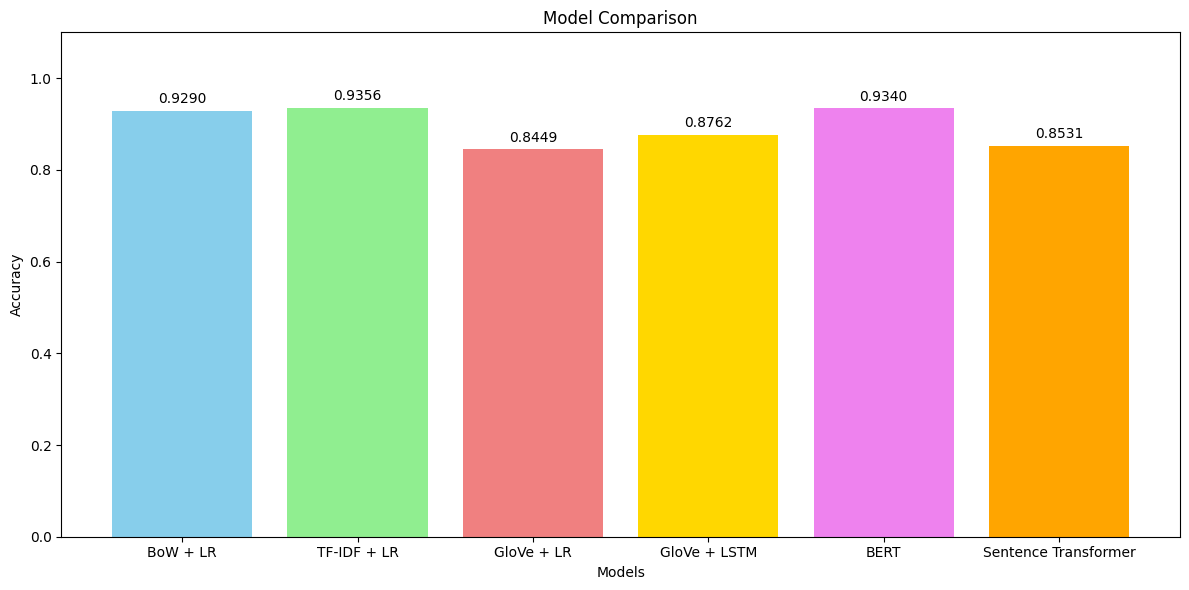

In [ ]:
compare_models(results)

In [ ]:
results

{'BoW + LR': 0.929042904290429,
 'TF-IDF + LR': 0.9356435643564357,
 'GloVe + LR': 0.8448844884488449,
 'GloVe + LSTM': 0.8762061407691554,
 'BERT': 0.933993399339934,
 'Sentence Transformer': 0.8531353135313532}

# Save Models for Inference

In [ ]:
models_dict = {
    'bow': (bow_model, bow_vectorizer),
    'tfidf': (tfidf_model, tfidf_vectorizer),
    'glove': glove_model,
    'glove_vectors': load_glove_embeddings('glove.6B.100d.txt'),
    'lstm': lstm_model,
    'bert': bert_model,
    'sentence_transformer': st_encoder,
    'sentence_transformer_model': st_model
}

with open('all_models.pkl', 'wb') as f:
    pickle.dump(models_dict, f)

# Example Prediction

In [ ]:
# Example prediction
sample_text = "Breaking News: President announces new policy that will change everything!"
predictions = predict_fake_news(sample_text, models_dict)

print("\nPredictions for sample text:")
print(f"Text: {sample_text}")
for model_name, result in predictions.items():
    confidence = result['confidence']
    confidence_str = f" (Confidence: {confidence:.4f})" if confidence is not None else ""
    print(f"{model_name}: {result['prediction']}{confidence_str}")

100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


Predictions for sample text:
Text: Breaking News: President announces new policy that will change everything!
BoW + Logistic Regression: Fake (Confidence: 0.6703)
TF-IDF + Logistic Regression: Fake (Confidence: 0.7460)
GloVe + Logistic Regression: Real (Confidence: 0.5046)
GloVe + LSTM: Fake (Confidence: 0.9862)
BERT: Fake
Sentence Transformer: Fake (Confidence: 0.5177)
